In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator_psc import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption, regplot, scatterplot
import copy
from IPython.display import display
from collections import defaultdict
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import pathlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['figure.figsize'] = (16,9)

In [3]:
# p = pathlib.Path('../cluster/results/')
# path = pathlib.Path('../longrun_new/')
# path = pathlib.Path('../cluster/long_run_4000/')
# path = pathlib.Path('../results/')
path = pathlib.Path('/home/mikkel/data/results/')

In [4]:
spikes_ex, spikes_in = [], []
for f in path.iterdir():
    if f.suffix == '.gdf':
        df = pd.read_csv(
            f, sep='\t', header=None).rename(columns={0:'sender', 1:'times'}).drop(columns=2)
        if f.stem.startswith('ex'):
            spikes_ex.append(df)
        else:
            spikes_in.append(df)
            
spikes_ex = pd.concat(spikes_ex)
spikes_in = pd.concat(spikes_in)

In [5]:
stim_data = np.load(path / 'stimulation_data_0.npz', allow_pickle=True)['data'][()]
stim_times = np.array(stim_data['times'])
stim_durations = np.array(stim_data['durations'])

In [6]:
spiketrains_ex = spikes_ex.groupby('sender')
spiketrains_in = spikes_in.groupby('sender')

In [7]:
import json
with open(str(path / 'params.json'), 'r') as f:
    params = json.load(f)

t_stop = params['status']['time']

In [8]:
conn = pd.read_feather('../params_1_psc_connections.feather')

In [9]:
# conn = pd.concat([pd.read_feather(p) for p in path.iterdir() if p.suffix == '.feather'])

In [10]:
conn.loc[:,'source_stimulated'] = conn.source.isin(stim_data['stim_nodes']['ex'])
conn.loc[:,'target_stimulated'] = conn.target.isin(stim_data['stim_nodes']['ex'])
conn.loc[:,'target_ex'] = conn.target.isin(spikes_ex.sender.unique())
conn['stim_amp_source'] = conn.progress_apply(
    lambda x: stim_data['stim_amps']['ex'].get(x.source, 0), axis=1)

HBox(children=(IntProgress(value=0, max=1600000), HTML(value='')))

In [11]:
np.min(np.diff(stim_times))

200.0

(800, 1200)

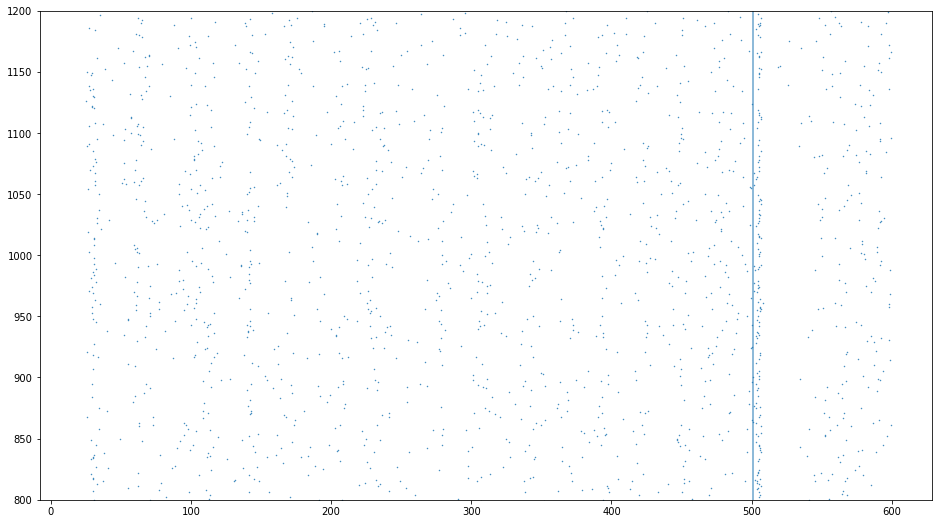

In [12]:
t1, t2 = 0, 600

mask = (spikes_ex.times >= t1) & (spikes_ex.times <= t2)
mask_s = (stim_times >= t1) & (stim_times <= t2)

plt.scatter(spikes_ex.times[mask], spikes_ex.sender[mask], s=.2)
# plt.xlim(590,640)
for s, d in zip(stim_times[mask_s], stim_durations[mask_s]):
    plt.axvspan(s, s+d, alpha=.5)
plt.ylim(800, 1200)

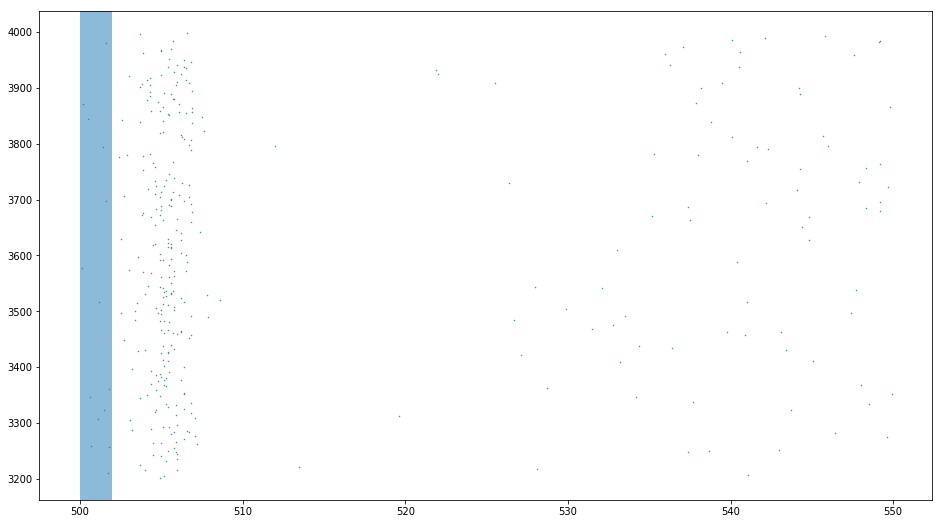

In [13]:
t1, t2 = 500, 550

mask = (spikes_in.times >= t1) & (spikes_in.times <= t2)
mask_s = (stim_times >= t1) & (stim_times <= t2)

plt.scatter(spikes_in.times[mask], spikes_in.sender[mask], s=.2)
# plt.xlim(590,640)
for s, d in zip(stim_times[mask_s], stim_durations[mask_s]):
    plt.axvspan(s, s+d, alpha=.5)

In [14]:
start_ai = 100
stop_ai = 500
duration = stop_ai - start_ai

In [15]:
def sslice(x, x1, x2):
    idx = np.searchsorted(x, [x1, x2], side='right')
    return x[idx[0]: idx[1]]

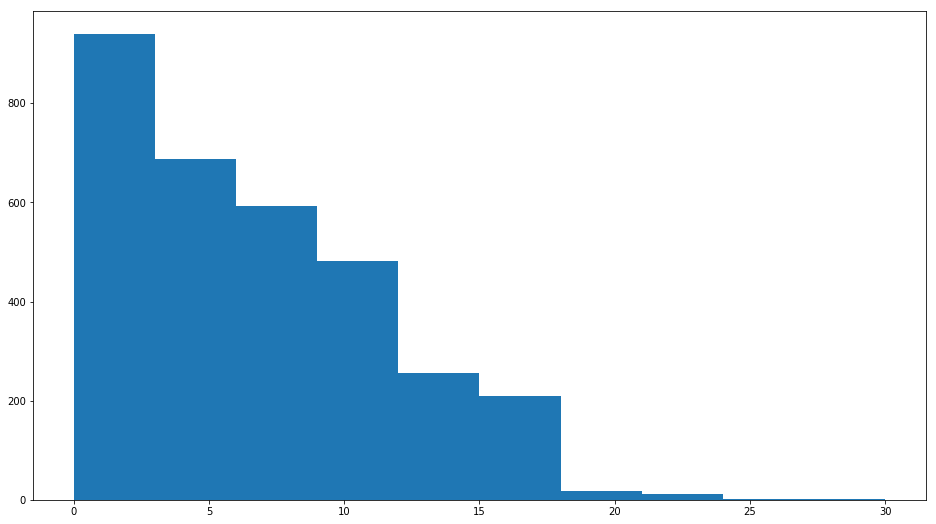

In [16]:
plt.hist([len(sslice(s.times, start_ai, stop_ai)) / (duration / 1000) 
          for i, s in spiketrains_ex]);

In [17]:
# fig, ax = plt.subplots(1, 2)


# binsize_corr = 2.
# spiketrains_list = [
#     s.times[(s.times > start_ai) & (s.times < stop_ai)] for i, s in spiketrains_ex
# ]

# cc = corrcoef(
#     np.random.choice(spiketrains_list, 400), t_stop, binsize=binsize_corr)

# cc = cc[np.triu_indices(len(cc), k=1)]
# cc = cc[~np.isnan(cc)]
# ax[0].hist(cc, bins=100);


# cv = np.array(coef_var(spiketrains_list))
# cv = cv[~np.isnan(cv)]

# ax[1].hist(cv, bins=100);

# stim related

In [14]:
def make_trials(stim_times, spikes, t1, t2):
    trials = []
    for i, t in enumerate(stim_times):
        idx = np.searchsorted(spikes, [t + t1, t + t2], side='right')
        trials.append(spikes[idx[0]: idx[1]] - t)
    return trials

In [27]:
def compute_stim_response(stim_times, spikes, x1, x2):
    stim_win = np.insert(
        stim_times + x1,
        np.arange(len(stim_times)) + 1,
        stim_times + x2)
    src_y = np.searchsorted(spikes, stim_win, side='right')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Y.astype(bool).astype(int)

In [28]:
trials = make_trials(stim_times, spiketrains_ex.get_group(1).times, 0, 30)

In [29]:
trial_spikes = [a for b in trials for a in b]
trial_ids = [a for i, b in enumerate(trials) for a in [i] * len(b)]

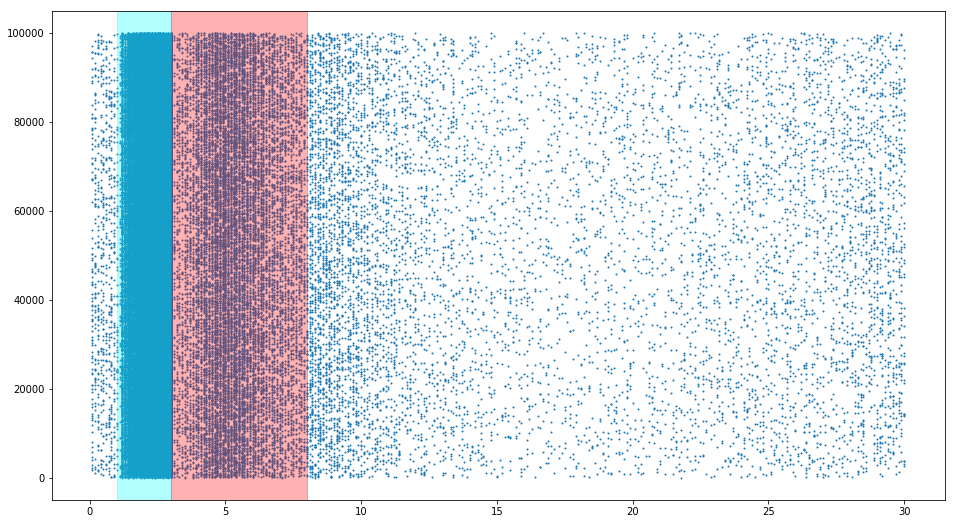

In [34]:
plt.scatter(trial_spikes, trial_ids, s=1)
plt.axvspan(1, 3, color='cyan', alpha=.3)
plt.axvspan(3, 8, color='r', alpha=.3)

In [15]:
for i, s in spiketrains_ex:
    print(s.sender.values)
    break

[1 1 1 ... 1 1 1]


In [53]:
x1 = 1
x2 = 3
hit_rates = [compute_stim_response(s.times, stim_times,  x1, x2).mean()
             for i, s in spiketrains_ex 
             if s.sender.iloc[0] in stim_data['stim_nodes']['ex']]


fig, ax = plt.subplots(1, 2)

amps = np.array(list(stim_data['stim_amps']['ex'].values()))
ax[0].hist(amps, bins=np.unique(amps))
ax[0].set_xlabel('Stim amps')

ax[1].hist(hit_rates)
ax[1].set_xlabel('Hit rate')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


HBox(children=(IntProgress(value=0, max=995), HTML(value='')))

ValueError: Length of passed values is 481708, index implies 240854

# look at all

In [25]:
def make_regressors(stim_times, spikes, z1=-2, z2=0, x1=1, x2=3, y1=3, y2=7):
    senders = spikes.sender
    times = spikes.times
    N = len(senders.unique())
    
    Z = np.ones((len(stim_times), N))
    X = np.zeros((len(stim_times), N))
    Y = np.zeros((len(stim_times), N))
    for i, t in enumerate(tqdm(stim_times)):

        idx = np.searchsorted(times, [t + z1, t + z2], side='right')
        id_spiked_before = senders[idx[0]: idx[1]]

        Z[i, id_spiked_before] = 0

        idx = np.searchsorted(times, [t + x1, t + x2], side='right')
        id_spiked = senders[idx[0]: idx[1]]
        X[i, id_spiked] = 1

        idx = np.searchsorted(times, [t + y1, t + y2], side='right')
        id_spiked = senders[idx[0]: idx[1]]
        Y[i, id_spiked] = 1
    return Z, X, Y

In [26]:
Z, X, Y = make_regressors(stim_times, spikes_ex)

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

KeyboardInterrupt: 

In [30]:
N = 200
# query = 'stim_amp_source > 600 and stim_amp_source < 800 and weight > 0 and not target_stimulated and target_ex'
query = 'weight > 0 and not target_stimulated and target_ex'
sample = conn.query(query)


In [31]:
sample.sort_values('weight', ascending=False).head()

,weight,source,target,source_stimulated,target_stimulated,target_ex,stim_amp_source
854645,1.999977,2138,2951,False,False,True,0.000000
1011297,1.999802,2530,1359,False,False,True,0.000000
494431,1.999735,1238,2670,False,False,True,0.000000
175600,1.999691,440,1854,True,False,True,2.991194
495142,1.999687,1240,1297,False,False,True,0.000000


In [32]:
sample['wr'] = sample.weight.round(3)
sample = sample.drop_duplicates('wr')

# sample = sample.sample(2000)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
len(sample)

2001

In [50]:
def process(row):
    source = spiketrains_ex.get_group(int(row.source)).times
    target = spiketrains_ex.get_group(int(row.target)).times
    z = compute_stim_response(stim_times, source, -2, 0)
    x = compute_stim_response(stim_times, source, 1, 3)
    y = compute_stim_response(stim_times, target, 3, 7)
    y_ref = y[z==0]
    y_respons = y[x==1].mean()
    beta_iv = y_respons - y_ref.mean()
#     wald = (y[z==1].mean() - y[z==0].mean()) / (x[z==1].mean() - x[z==0].mean())
#     beta = y_respons - y[x==0].mean()
    beta = y_respons - np.random.choice(y[x==0], len(y_ref)).mean()
#     return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean(), 'wald': wald})
    return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean()})

In [34]:
process(sample.iloc[0,:])

beta       -0.503316
beta_iv    -0.143605
hit_rate    0.707160
dtype: float64

In [35]:
from multiprocessing import  Pool

def parall_apply(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def apply(x): 
    return x.apply(process, axis=1, result_type="expand")

In [51]:
# result = sample.join(sample.progress_apply(process, axis=1, result_type="expand"))
result = sample.join(parall_apply(sample, apply))

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

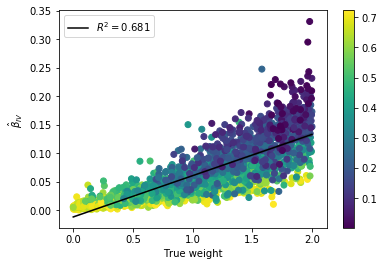

In [52]:
df_ = result#.query('hit_rate > .3 and hit_rate < .8')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

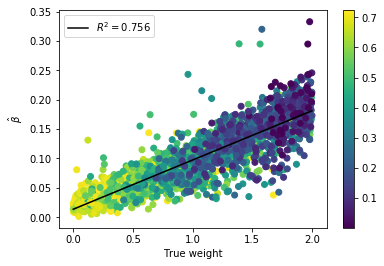

In [53]:
df_ = result#.query('hit_rate > .3 and hit_rate < .8')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'$\\hat{\\beta}$')

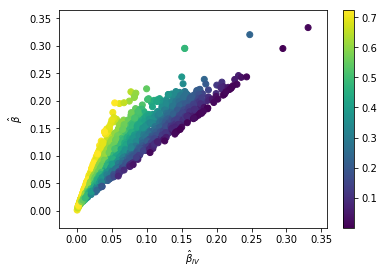

In [54]:
scatterplot(
    'beta_iv', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'True weight')

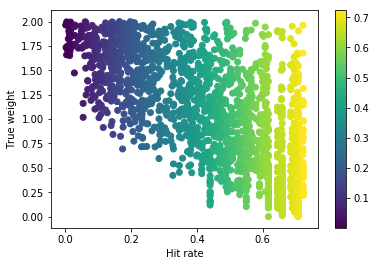

In [55]:
scatterplot(
    'hit_rate', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Hit rate')
plt.ylabel('True weight')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

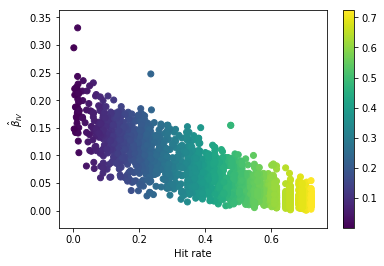

In [56]:
scatterplot(
    'hit_rate', 'beta_iv', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

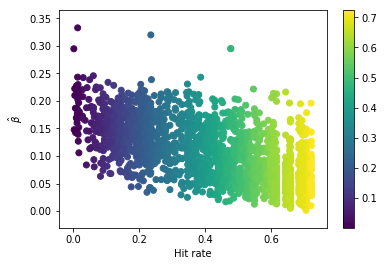

In [57]:
scatterplot(
    'hit_rate', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

Text(0.5,0,'source')

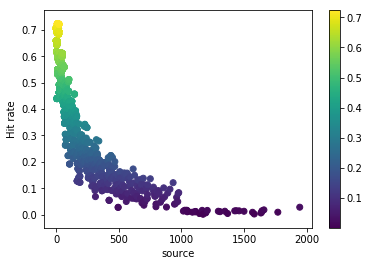

In [58]:
model = scatterplot(
    'source', 'hit_rate', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.ylabel(r'Hit rate')
plt.xlabel(r'source')